# Хакатон "Геомодель" задача 2
## Исследовательский анализ данных

**Summary**   

* положение точек удара не симметрично и важно учитывать не только расстояние до сенсора, но и его положение  
* 40-50Гц часто являются границей информативного сигнала  
* в низкочастотной области различия между моделями 9м и 14м - максимальны, для низких частот характерно большая амплитуда для 14м-моделирования, для высоких большая амплитуда для 9м-моделирования


In [1]:
import h5py
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
import geopandas as gpd
import pandas as pd

In [2]:
file_path_9 = r'data\9m\batch_9m.hdf5'
file_path_14 = r'data\14m\batch_14m.hdf5'
file_points_data_path = r'data\points_data.txt'
file_sensors_data_path = r'data\sensors_data.txt'

In [3]:
with open(file_sensors_data_path) as f:
    sensors_data = [line.split() for line in f]

In [4]:
points_data = []
with open(file_points_data_path) as f:
    points_data = ([line.split() for line in f])

Примеры и количетсво данных

In [5]:
print(f'Точки удара: {points_data}')
print(f'Примеры данных на сенсорах: {sensors_data[:3]}')
print(f'Количество точке удара {len(points_data)}')
print(f'Количество сенсоров {len(sensors_data)}')

Точки удара: [['p1', '1688435.91', '6650534.22', '0'], ['p2', '1688435.91', '6650034.22', '0']]
Примеры данных на сенсорах: [['1', '1683627.62', '6645407.23', '0'], ['2', '1683627.62', '6645607.23', '0'], ['3', '1683627.62', '6645807.23', '0']]
Количество точке удара 2
Количество сенсоров 2016


Рассчёт расстояний и построение "карты" сенсоров и точек удара  

*Если задать карте большый размер точки удара "расклеятся", будет заметно различное их положение*

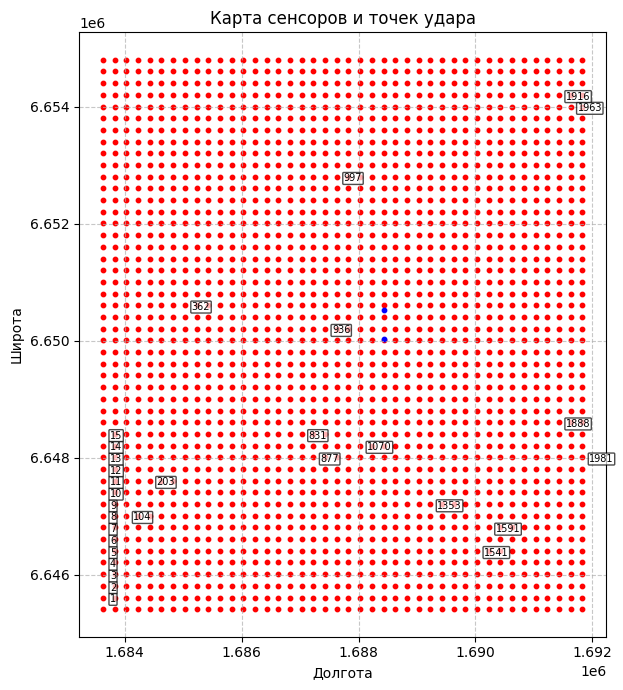

In [6]:
df = gpd.GeoDataFrame(sensors_data, columns=(['sensor_name', 'x', 'y', 'z']))
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], df['z']))
df_impact = gpd.GeoDataFrame(points_data, columns=(['sensor_name', 'x', 'y', 'z']))
df_impact = gpd.GeoDataFrame(df_impact, geometry=gpd.points_from_xy(df_impact['x'], df_impact['y'], df_impact['z']))

fig, ax = plt.subplots(figsize=(7, 7))


df.plot(ax=ax, color='red', markersize=10, label='Sensors')
df_impact.plot(ax=ax, color='blue', markersize=10, label='Impact Points')


sparse_tmp = df.head(15)
sparse_tmp = pd.concat([sparse_tmp, df.sample(15)])
for x, y, name in zip(sparse_tmp['x'], sparse_tmp['y'], sparse_tmp['sensor_name']):
    ax.annotate(
        text=name,
        xy=(float(x), float(y)),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=7,
        bbox=dict(boxstyle="round,pad=0.1", fc="white", alpha=0.7)  # Better readability
    )

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel("Долгота")
ax.set_ylabel("Широта")
ax.set_title("Карта сенсоров и точек удара")
#ax.legend()

plt.tight_layout() 
plt.show()


По карте видно, что точки удара находятся не совсем "в центре".   
Проверим данные - построим гистограмму, проверим чтобы не было аномалий

,sensor_name,x,y,z,geometry,dist_to_p1,dist_to_p2
1329,1330,1689027.62,6652007.23,0,POINT Z (1689027.62 6652007.23 0),1587.412733,2059.827465
126,127,1684027.62,6651407.23,0,POINT Z (1684027.62 6651407.23 0),4493.903335,4617.161161
1777,1778,1691027.62,6645607.23,0,POINT Z (1691027.62 6645607.23 0),5567.063066,5129.834421


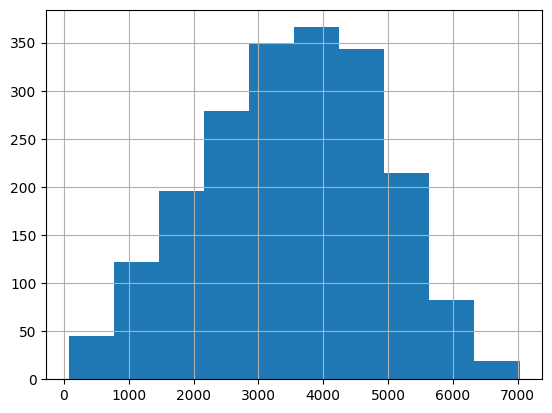

In [7]:
for _, impact_point in df_impact.iterrows():
    impact_name = impact_point['sensor_name']
    distances = df.geometry.distance(impact_point.geometry)
    df[f'dist_to_{impact_name}'] = distances

df.dist_to_p1.hist()

df.sample(3)

**Изучим** состав данных с сенсоров

In [10]:
def walk_groups(group):
    pattern =r'(\d{1,4}_([XYZ]))'
    for key in group.keys():
        if not bool(re.match(pattern, key)):
            if isinstance(group[key], h5py.Group):
                print(f'\nГруппа: {key}')
                walk_groups(group[key])
            elif isinstance(group[key], h5py.Dataset):
                dataset = group[key]
                print(f'Набор данных: {dataset.name}, форма: {dataset.shape}, dtype: {dataset.dtype}')

def explore_hdf5(file_path):
    pattern =r'(\d{1,4}_([XYZ]))'
    with h5py.File(file_path, 'r') as f:
        print("=== Группы ===")
        for group in f.keys():
            if not bool(re.match(pattern, group)):
                print(f'Группа: {group}')       
                walk_groups(f)
    
file_path = r'data\14m\batch_14m.hdf5'
explore_hdf5(file_path)

=== Группы ===
Группа: Channels

Группа: Channels
Набор данных: /L, форма: (1,), dtype: int32
Набор данных: /fd, форма: (1,), dtype: int32
Набор данных: /grid_step, форма: (3,), dtype: int64
Набор данных: /sensors, форма: (2016,), dtype: object
Группа: L

Группа: Channels
Набор данных: /L, форма: (1,), dtype: int32
Набор данных: /fd, форма: (1,), dtype: int32
Набор данных: /grid_step, форма: (3,), dtype: int64
Набор данных: /sensors, форма: (2016,), dtype: object
Группа: fd

Группа: Channels
Набор данных: /L, форма: (1,), dtype: int32
Набор данных: /fd, форма: (1,), dtype: int32
Набор данных: /grid_step, форма: (3,), dtype: int64
Набор данных: /sensors, форма: (2016,), dtype: object
Группа: grid_step

Группа: Channels
Набор данных: /L, форма: (1,), dtype: int32
Набор данных: /fd, форма: (1,), dtype: int32
Набор данных: /grid_step, форма: (3,), dtype: int64
Набор данных: /sensors, форма: (2016,), dtype: object
Группа: sensors

Группа: Channels
Набор данных: /L, форма: (1,), dtype: int32

In [11]:
batch_name_14 = h5py.File(file_path_14)
batch_name_9 = h5py.File(file_path_9)

In [14]:
print(f'Количество каналов 14м: {len(batch_name_14["Channels"].keys())}')
print(f'Количество каналов 9м: {len(batch_name_9["Channels"].keys())}')

for i in range(500, 1000, 38):
    sensor_name = str(i)+"_X"
    print(batch_name_9['Channels'][sensor_name]['data'][:].shape)

Количество каналов 14м: 6048
Количество каналов 9м: 6048
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)
(2, 6, 1250)


**Изучим** как выглядит волна на отдельных сенсорах.  
**Расмотрим** разные компоненты тензора

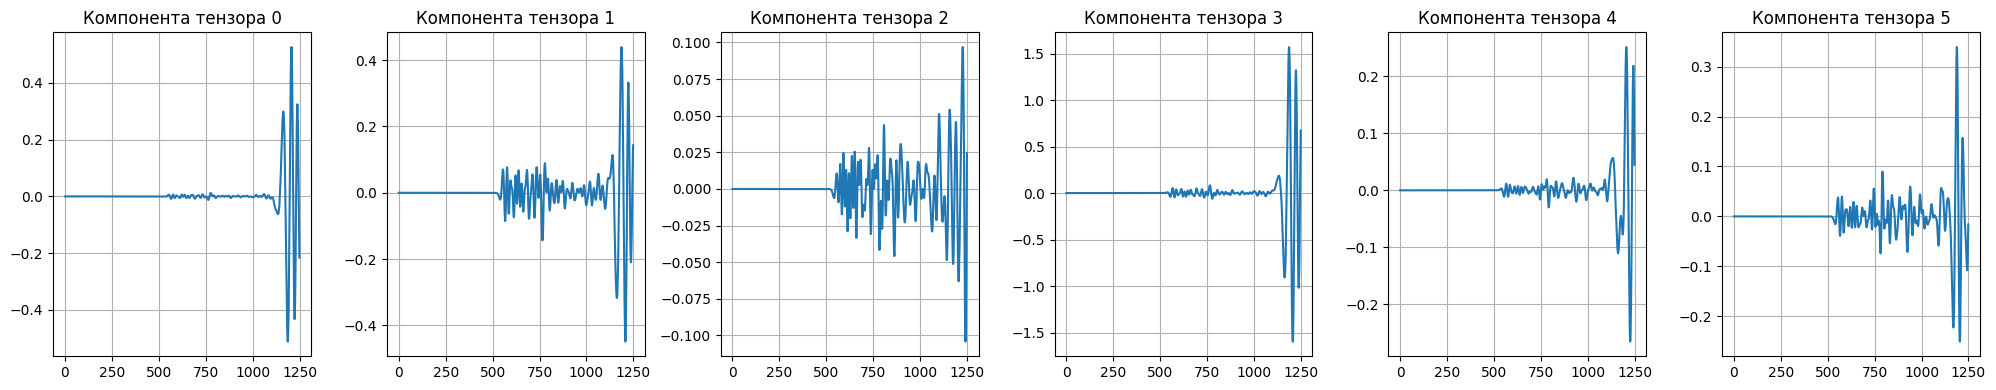

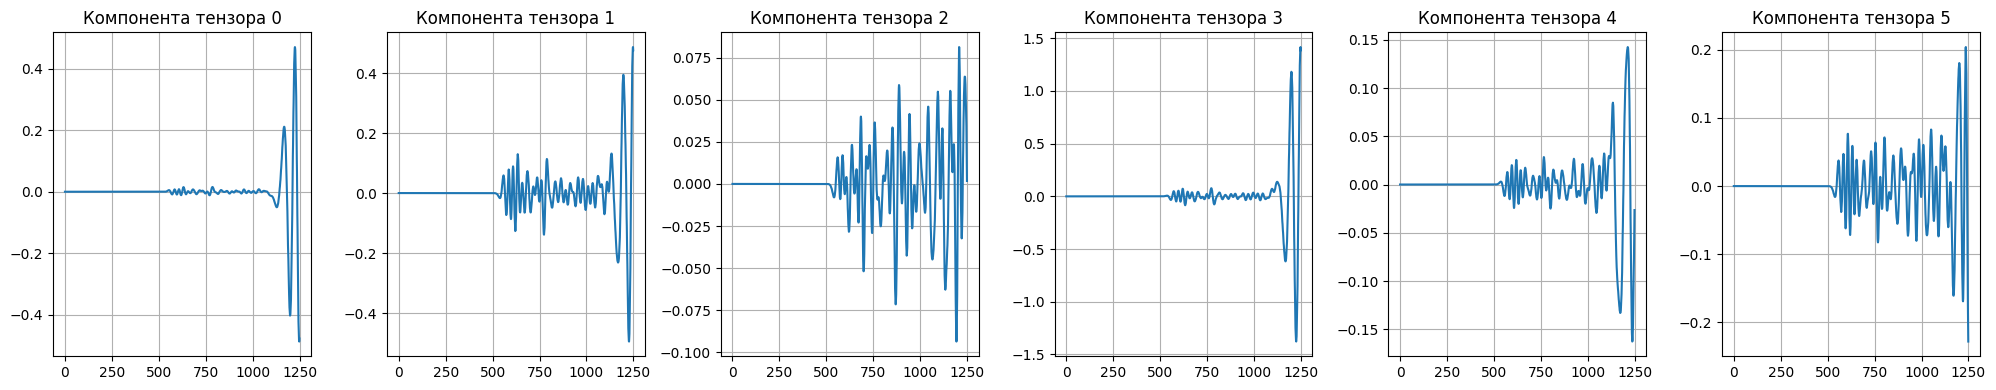

In [15]:
values = []
for i in range(6):
    values.append(batch_name_9['Channels']['1000_X']['data'][:][0][i])

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4)) 
for i, ax in enumerate(axes):
    ax.plot(values[i])
    ax.set_title(f'Компонента тензора {i}') 
    ax.grid(True)
plt.tight_layout()
plt.show()

values = []
for i in range(6):
    values.append(batch_name_14['Channels']['1000_X']['data'][:][0][i])

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4)) 
for i, ax in enumerate(axes):
    ax.plot(values[i])
    ax.set_title(f'Компонента тензора {i}') 
    ax.grid(True)
plt.tight_layout()
plt.show()

**Рассмотрим** частотные диаграммы этих сигналов  

Также можно участь ответы орагнизаторов:
*Здравствуйте.
Можно ли задать вопрос по второй задаче?
Исходя из обсуждения в канале, я поняла, что высокие частоты - это примерно от 49 Гц.
Правильно ли я понимаю, что выше 100 Гц сигнал не имеет смысла рассматривать?*  

**Здравствуйте! 
Да, можно обрезать, так как в предыдущем ответе написал, что у 9 м ячейки не информативный звон начинается выше 65 Гц, а у 14 м еще ниже по частоте.
P.S. Главное, чтобы расхождение по метрике MAE было минимальным.**

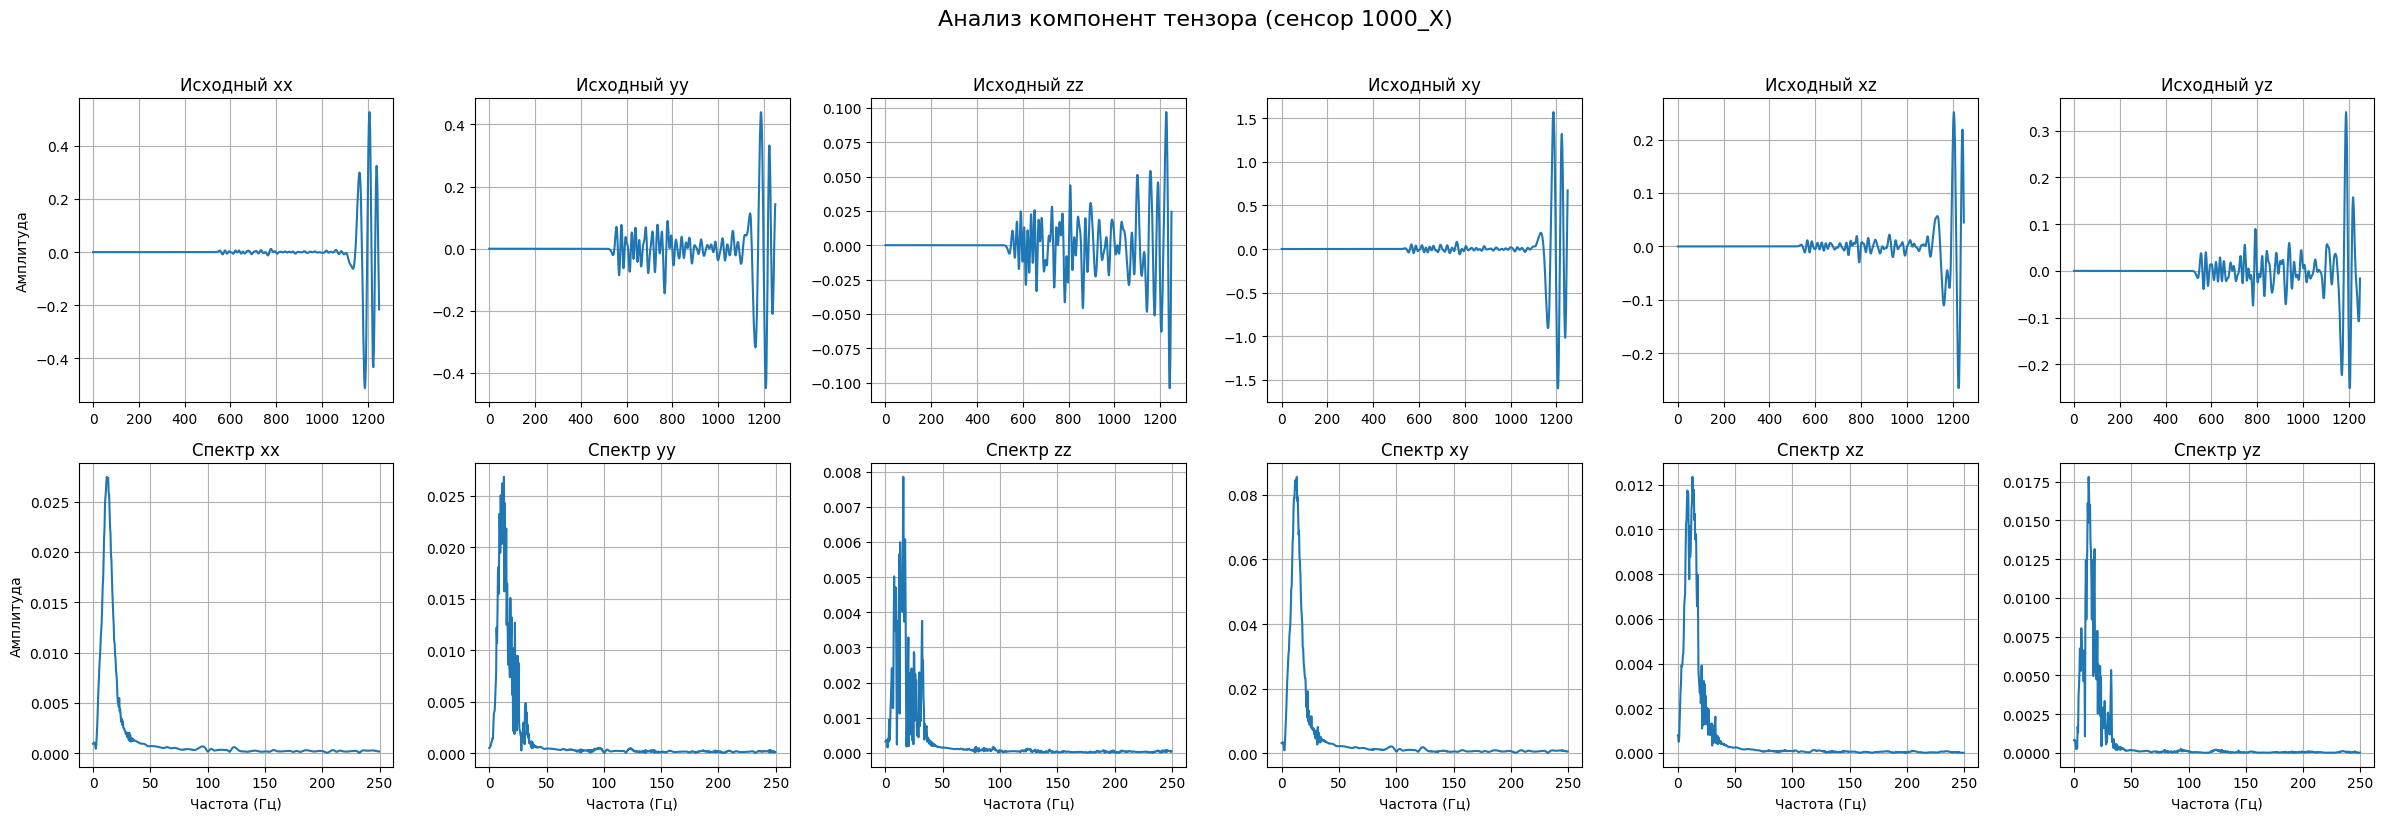

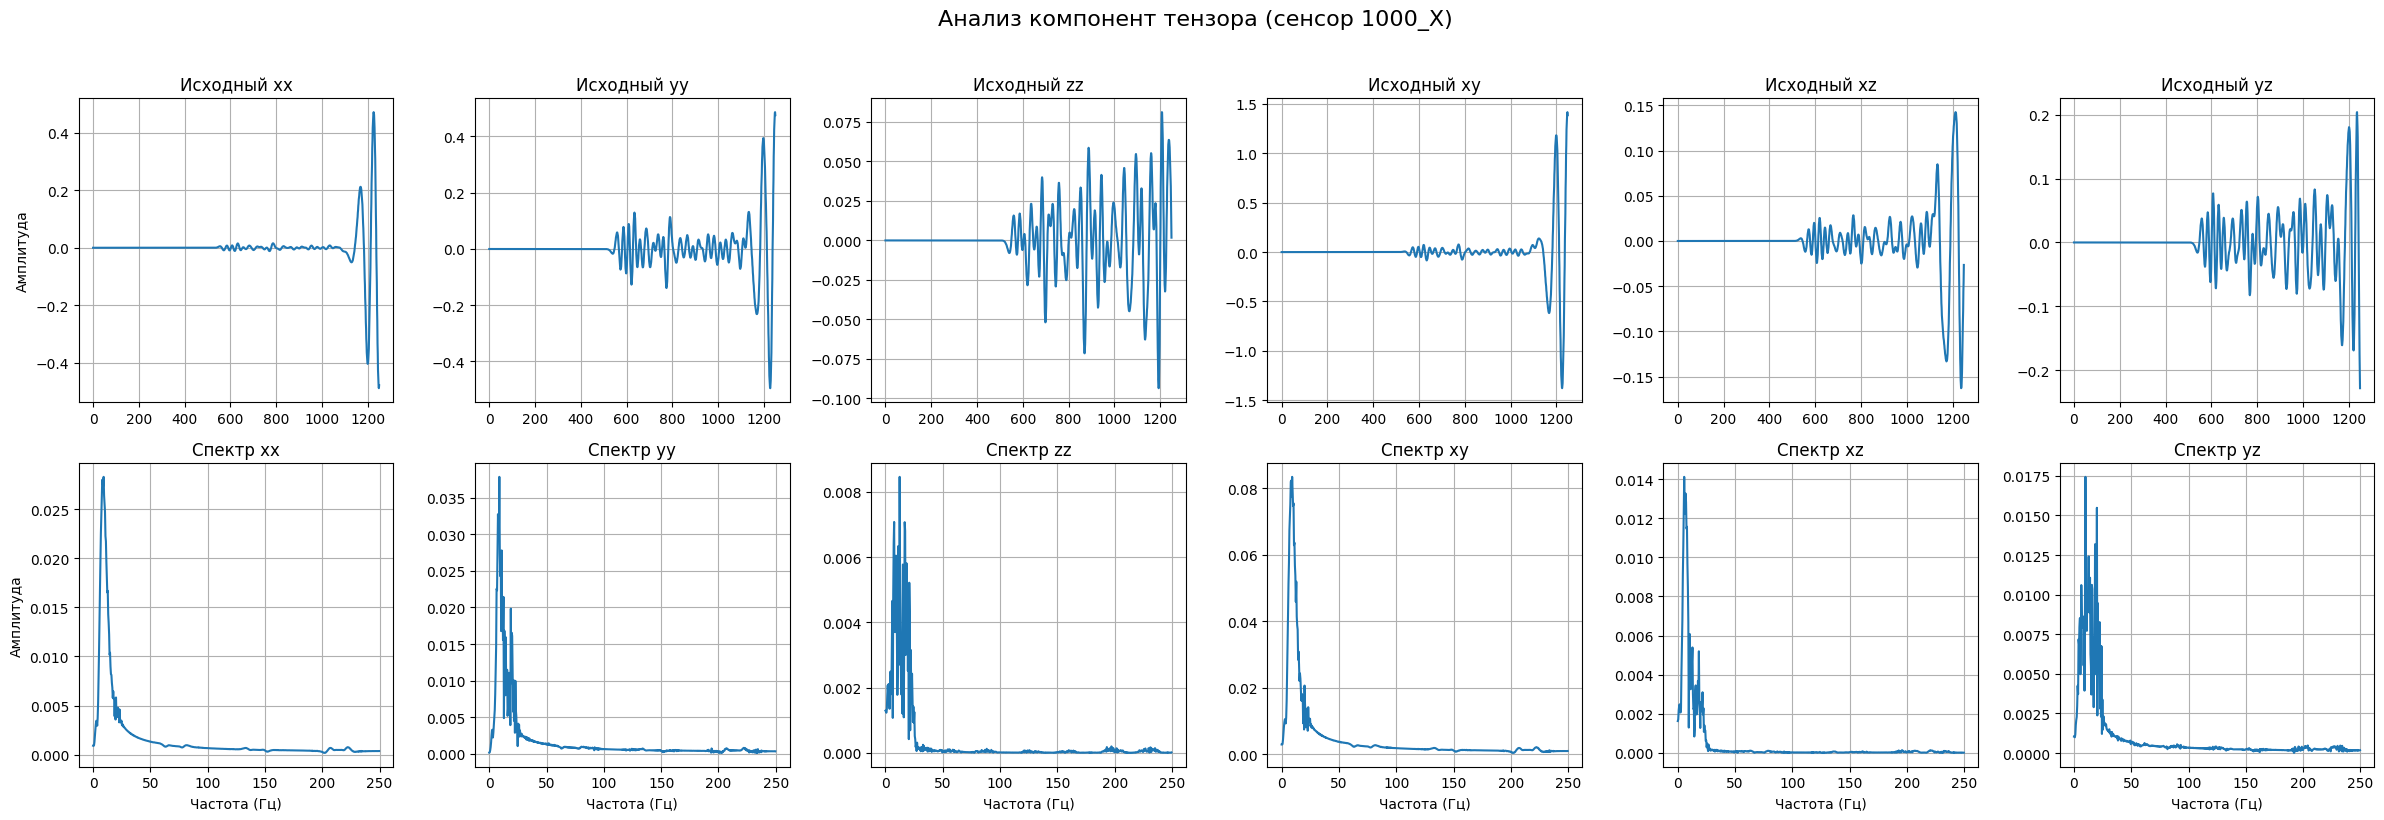

In [16]:
def plot_sensor_data(batch_name, sensor_name):
    values = []
    for i in range(6):
        values.append(batch_name['Channels'][sensor_name]['data'][:][0][i])

    n = len(values[0])
    fd = batch_name['fd'][()]
    T = 1.0 / fd 

    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(24, 8))
    component_names = ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']

    for i in range(len(component_names)):
        axes[0, i].plot(values[i])
        axes[0, i].set_title(f'Исходный {component_names[i]}')
        axes[0, i].grid(True)
        
        yf = fft(values[i])
        xf = fftfreq(n, T)[:n//2] 
        
        axes[1, i].plot(xf, 2.0/n * np.abs(yf[:n//2]))
        axes[1, i].set_title(f'Спектр {component_names[i]}')
        axes[1, i].grid(True)
        axes[1, i].set_xlabel('Частота (Гц)')

    fig.suptitle(f'Анализ компонент тензора (сенсор {sensor_name})', fontsize=16, y=1.02)
    axes[0, 0].set_ylabel('Амплитуда')
    axes[1, 0].set_ylabel('Амплитуда')

    plt.tight_layout()
    plt.show()

plot_sensor_data(batch_name_9, "1000_X")
plot_sensor_data(batch_name_14, "1000_X")


**Сравним** разницу между моделированием с разной 

In [17]:
def plot_comparison(batch_1, batch_2, impact_point, sensor_name, component_name, labels):
    component_names = ['xx', 'yy', 'zz', 'xy', 'xz', 'yz']
    component_ind = component_names.index(component_name)
    values_1 = batch_1['Channels'][sensor_name]['data'][:][impact_point][component_ind]
    values_2 = batch_2['Channels'][sensor_name]['data'][:][impact_point][component_ind]


    n = len(values_1)
    fd = batch_1['fd'][()]
    T = 1.0 / fd 
    if n != len(values_2):
        if fd != batch_2['fd'][()]:
            print(f'Параметры преобразования Фурье не равны для батчей')
    
    yf_1 = fft(values_1)
    yf_2 = fft(values_2)
    xf = fftfreq(n, T)[:n//2] 

    figsize = (12, 8)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    axes[0, 0].plot(values_1)
    axes[0, 0].set_title(f'Сейсмограмма для {impact_point}:{sensor_name}:{component_name}')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(xf, 2.0/n * np.abs(yf_1[:n//2]))
    axes[0, 1].set_title(f'Спектр {impact_point}:{sensor_name}:{component_name}')
    axes[0, 1].grid(True)
    axes[0, 1].set_xlabel('Частота (Гц)')

    axes[1, 0].plot(values_2)
    axes[1, 0].set_title(f'Сейсмограмма для {impact_point}:{sensor_name}:{component_name}')
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(xf, 2.0/n * np.abs(yf_2[:n//2]))
    axes[1, 1].set_title(f'Спектр {impact_point}:{sensor_name}:{component_name}')
    axes[1, 1].grid(True)
    axes[1, 1].set_xlabel('Частота (Гц)')

    fig.suptitle(f'Анализ данных (сенсор {sensor_name})', fontsize=16, y=1.02)
    axes[0, 0].set_ylabel('Амплитуда')
    axes[1, 0].set_ylabel('Амплитуда')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].plot(values_1, label=labels[0])
    axes[0].plot(values_2, label=labels[1])
    axes[0].legend(loc="best") 
    axes[1].plot(xf, 2.0/n * np.abs(yf_1[:n//2]), label=labels[0])
    axes[1].plot(xf, 2.0/n * np.abs(yf_2[:n//2]), label=labels[1])
    axes[1].set_xlim((0, 70))  # устанавливаем пределы оси X от 0 до 70 Гц
    axes[1].legend(loc="best") 

    fig.suptitle(f'Сравнение данных по разным разрешениям моделирования (сенсор {sensor_name})', fontsize=16, y=1.02)
    axes[0].set_ylabel('Амплитуда')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    labl = f'{labels[0]} - {labels[1]}'
    axes[0].plot(values_1-values_2, label=labl)
    axes[0].legend(loc="best") 
    axes[0].grid(True)
    axes[1].plot(xf, 2.0/n * (np.abs(yf_1[:n//2])-np.abs(yf_2[:n//2])), label=labl)
    axes[1].legend(loc="best") 
    axes[1].set_xlim((0, 70))
    axes[1].grid(True)

    fig.suptitle(f'Раница (сенсор {sensor_name})', fontsize=16, y=1.02)
    axes[0].set_ylabel('Амплитуда')
    plt.tight_layout()
    plt.show()


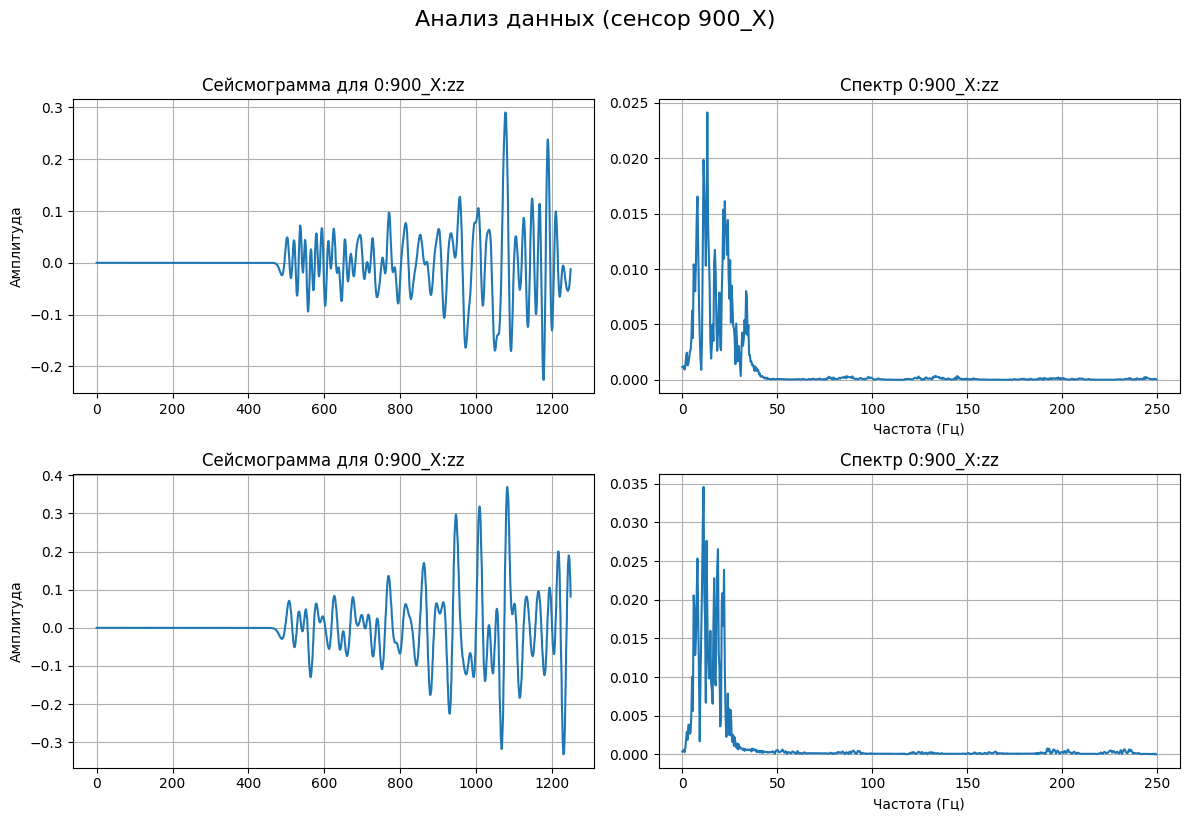

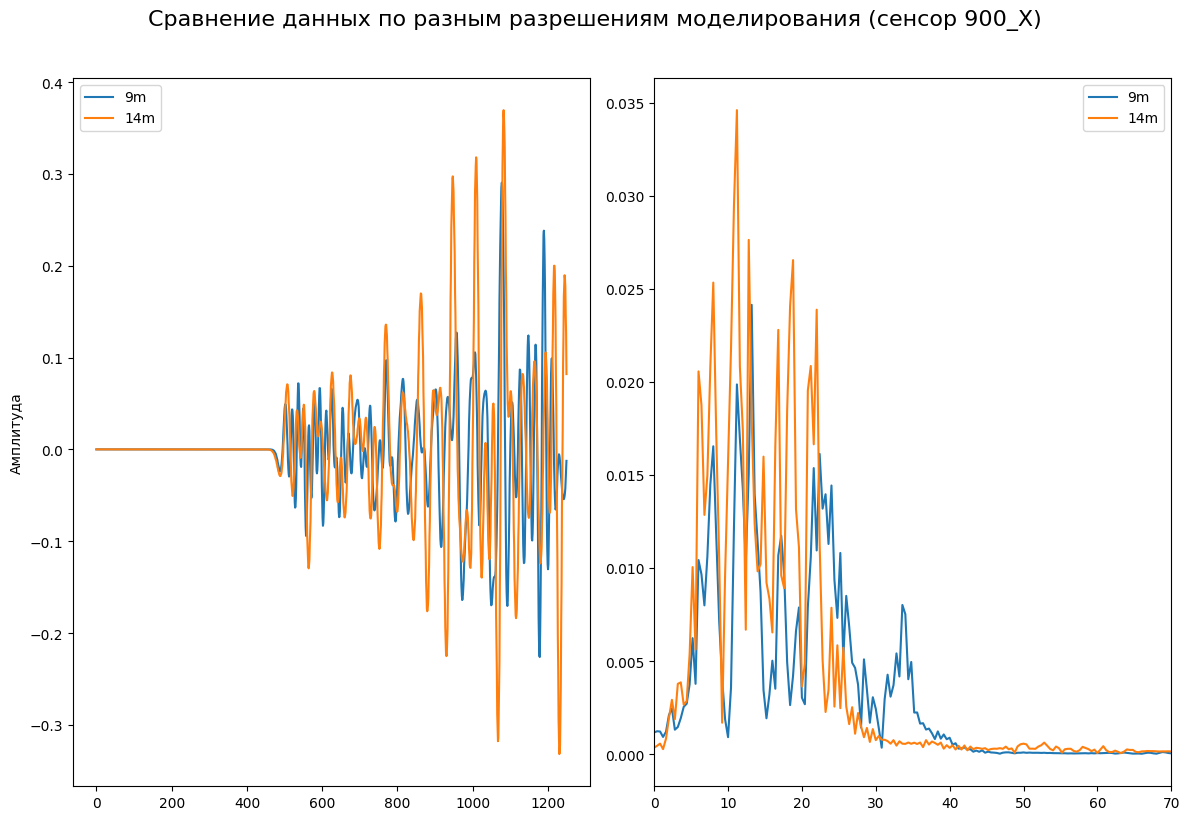

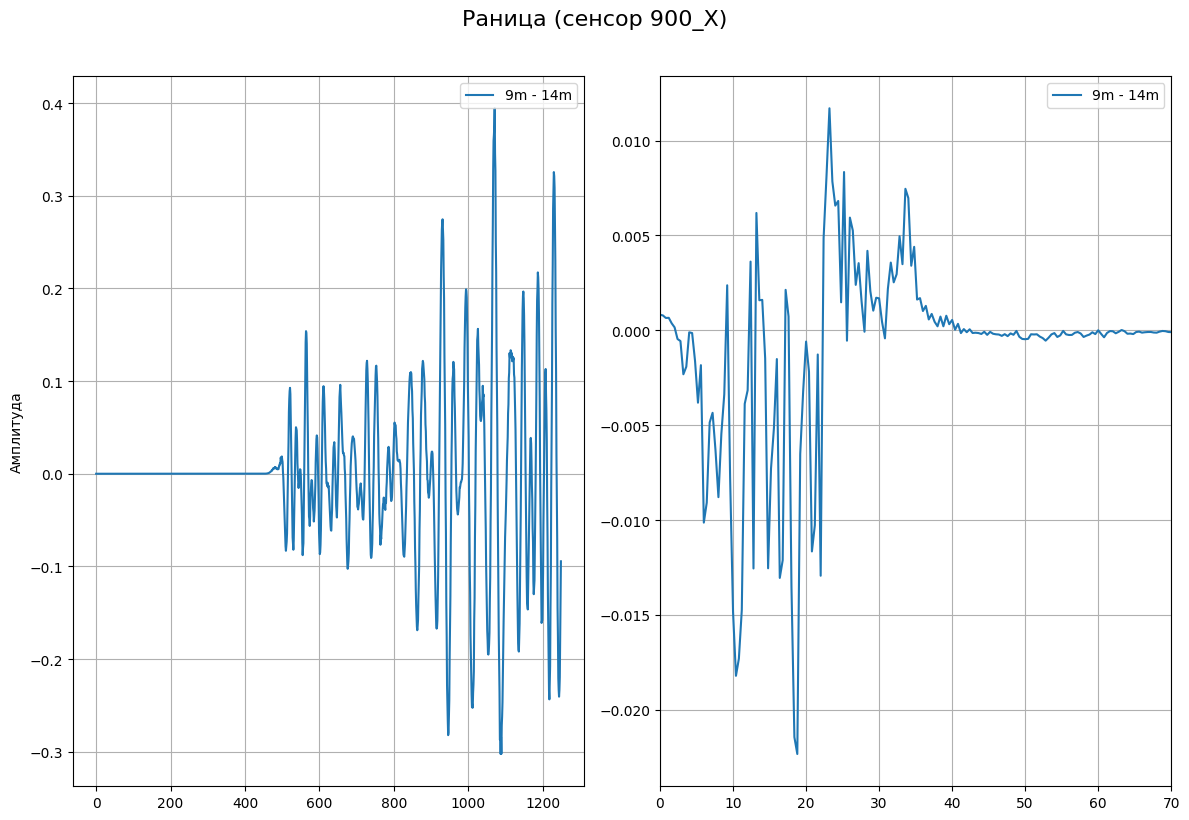

In [18]:
plot_comparison(batch_name_9, batch_name_14, 0, "900_X", 'zz', ['9m', '14m'])